Equipment type (ex. trucks, different model), usage (years used, older less expensive), odometer (higher lower price), number of breakdowns(more lower price), Horse Power(higher more price), Type of Engine(more cylinders, weight?), Use purpose (plowing snow), Type of tires, Geographic location, diesel vs gasoline, gear transmissions, power steering, attachments (categorical, more attachment higher)

In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

%matplotlib inline

# Data Cleaning

In [3]:
def funnel_convert(df):
    df = df.loc[:,df.count()>300000]
    df = df.loc[:,[(len(df[column].unique())<10) if df[column].dtype.name == 'object' else True for column in df.columns]]
    return df
def change_dates(df):
    df['year_change'] = df['YearMade'] == 1000
    mean = df[df['YearMade']!=1000]['YearMade'].mean()
    df['YearMade'] = df['YearMade'].replace(1000, mean)
    df['saledate_converted'] = pd.to_datetime(df.saledate)
    return df
def fill_na(df):
    df['Enclosure_change'] = df['Enclosure'].isnull()
    df['Enclosure'] = df['Enclosure'].fillna(method='ffill')
    return df

In [4]:
df = (pd.read_csv('data/train.csv')
      .pipe(change_dates)
      .pipe(fill_na)
      .pipe(funnel_convert)
      .drop(['ProductGroupDesc'],axis=1)
      )

# Feature engineering, idea: cars purchased around the same time should cost the same, so why not tractors?

In [126]:

class ComputeNearestMean(BaseEstimator, TransformerMixin):
    """Compute a mean price for similar vehicles.
    """
    def __init__(self, window=5):
        self.window = window

    def get_params(self, **kwargs):
        return {'window': self.window}

    def fit(self, X):
        X = X.sort_values(by=['saledate_converted'])
        g = X.groupby('ModelID')['SalePrice']
        m = g.apply(lambda x: x.rolling(self.window).agg([np.mean]))

        ids = X[['saledate_converted', 'ModelID', 'SalesID']]
        z = pd.concat([m, ids], axis=1)
        z['saledate_converted'] = z.saledate_converted + timedelta(1)

        # Some days will have more than 1 transaction for a particular model,
        # take the last mean (which has most info)
        z = z.drop('SalesID', axis=1)
        groups = ['ModelID', 'saledate_converted']
        self.averages = z.groupby(groups).apply(lambda x: x.tail(1))

        # This is kinda unsatisfactory, but at least ensures
        # we can always make predictions
        self.default_mean = X.SalePrice.mean()
        return self

    def transform(self, X):
        near_price = pd.merge(self.averages, X, how='outer',
                              on=['ModelID', 'saledate_converted'])
        nxcols = ['ModelID', 'saledate_converted']
        near_price = near_price.set_index(nxcols).sort_index()
        g = near_price['mean'].groupby(level=0)
        filled_means = g.transform(lambda x: x.fillna(method='ffill'))
        near_price['filled_mean_price'] = filled_means
        near_price = near_price[near_price['SalesID'].notnull()]
        missing_mean = near_price.filled_mean_price.isnull()
        near_price['no_recent_transactions'] = missing_mean
        near_price['filled_mean_price'].fillna(self.default_mean, inplace=True)
        return near_price

In [131]:
nearest_mean = ComputeNearestMean()
df = nearest_mean.fit_transform(df)

In [155]:
df.describe()

,mean,SalesID,SalePrice,MachineID,datasource,auctioneerID,YearMade,filled_mean_price
count,58843.000000,4.011250e+05,401125.000000,4.011250e+05,401125.000000,380989.000000,401125.000000,401125.000000
mean,30983.806784,1.919713e+06,31099.712848,1.217903e+06,134.665810,6.556040,1993.757403,31099.692159
std,20925.823786,9.090215e+05,23036.898502,4.409920e+05,8.962237,16.976779,9.211757,21016.725225
min,5050.000000,1.139246e+06,4750.000000,0.000000e+00,121.000000,0.000000,1919.000000,4950.000000
25%,16000.000000,1.418371e+06,14500.000000,1.088697e+06,132.000000,1.000000,1989.000000,15470.000000
50%,24600.000000,1.639422e+06,24000.000000,1.279490e+06,132.000000,2.000000,1995.000000,25600.000000
75%,39300.000000,2.242707e+06,40000.000000,1.468067e+06,136.000000,4.000000,2000.000000,39000.000000
max,139000.000000,6.333342e+06,142000.000000,2.486330e+06,172.000000,99.000000,2013.000000,140000.000000


# Plot to find any continuous data trends

In [115]:
scatter_df = df[['SalePrice', 'YearMade', 'filled_mean_price']]

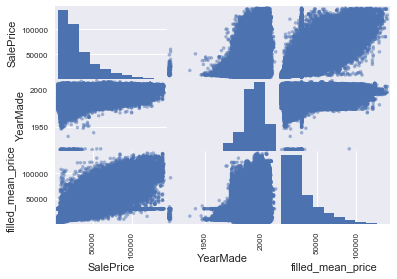

In [76]:
fig = plt.figure(figsize = (40,40))
pd.plotting.scatter_matrix(scatter_df)
plt.show()

We observe there is a slight linear relationship between the Sale price and when the model was made as well as a slight relationship between filled mean price and SalePrice

In [116]:
scatter_df.corr()

,SalePrice,YearMade,filled_mean_price
SalePrice,1.000000,0.211406,0.865865
YearMade,0.211406,1.000000,0.173538
filled_mean_price,0.865865,0.173538,1.000000


When we inspect the correlation coefficient (pearsons coefficent), we can see a rather strong linear relationship between filled_mean_price and SalePrice

In [117]:
stats.pearsonr(scatter_df['SalePrice'],scatter_df['filled_mean_price'])

(0.86586541936316164, 0.0)

Our p-value is well below a 0.05 threshold

# Explore features for categorical variables

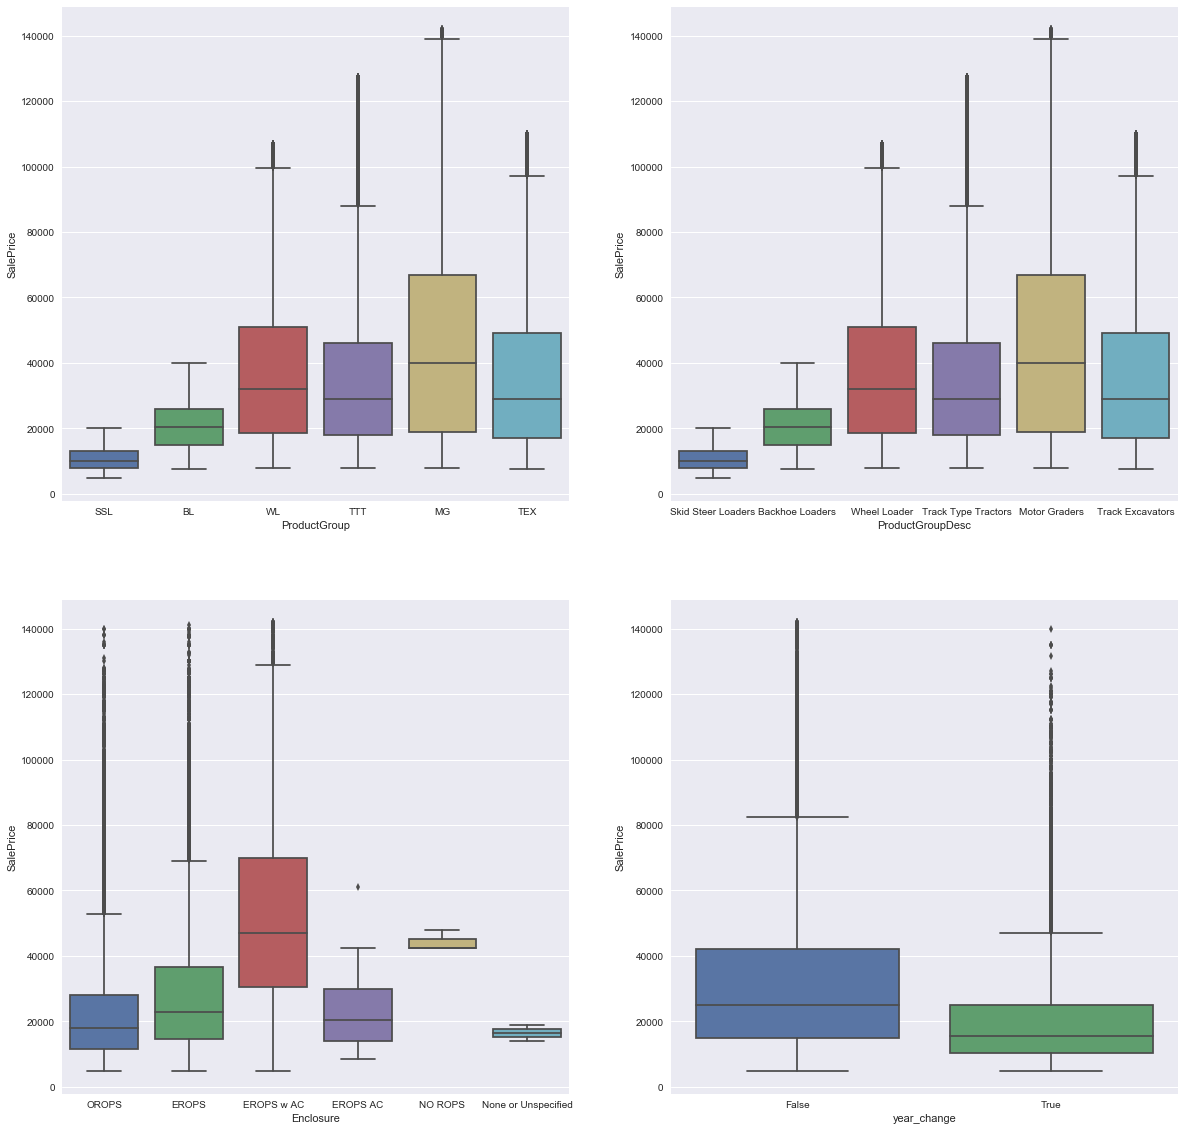

In [138]:
fig = plt.figure(figsize = (20,20))
index = 0
for column in df.columns:
    if (df[column].dtype.name == 'object'):
        index += 1
        ax = fig.add_subplot(2,2,index)
        sns.boxplot(df[column],df['SalePrice'])
plt.show()


With 24000 as our median price, two interesting categories to explore are SSL, and MG within Product group, EROPS w/ AC in our enclosure group. The year_change categories contain several outliers, so we are no confident in investigating these.

# Conclusion

Although the data was initially very messy. We were able to simplify analysis by cutting it down to examining columns with at least 75% data present.

We then created a column that used our intuition of cars sold around the same time should cost the same. 

With all our data filled in and present we begin plotting them. From our scatterplot we see our created column has a strong linear relationship with the price, and year sold a little less so. We quantify this visualization by finding the correlation between them, which by default is pearsons. Surely enough, our generated column has a high correlation.

After confirming tractors that are sold around the same time cost the same, we want to know which features make a particular tractor more valuable. Here we create a boxplot for our features and notice EROPS with AC tend to be worth more, and skid steer loaders tend to be worth a little less
